---

## Universidad de Costa Rica
### Escuela de Ingeniería Eléctrica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas

Segundo semestre del 2020

---

* Estudiante: **Isabel Vargas Sibaja**
* Carné: **B57628**
* Grupo: **1**


# `P5` - Análisis y predicción del consumo diario de energía

> Esta actividad extiende el análisis y modelado realizados anteriormente sobre la demanda eléctrica del país a partir de una base de datos del Instituto Costarricense de Electricidad, del 2019. El estudio se orienta ahora en el uso de las cadenas de Markov para determinar la probabilidad de ocurrencia de múltiples estados para el consumo energético diario.

---
* Elaboración de nota teórica y demostración: **Jeaustin Sirias Chacón**, como parte de IE0499 - Proyecto Eléctrico: *Estudio y simulación de aplicaciones de la teoría de probabilidad en la ingeniería eléctrica*.
* Revisión: **Fabián Abarca Calderón**


---
## 1. - El último vals: *Las cadenas de Markov*

En el proyecto programado anterior (`P4` - Modulación digital IQ) se estudiaron los **procesos estocásticos**. Algunos de estos tienen la **propiedad de Markov**, según la cual se puede decir que provoca en el sistema una especie de "amnesia" al momento de determinar *valores futuros* y condiciona la determinación de probabilidades a partir **únicamente** de los valores presentes.

## 2. - Construyendo un modelo energético con cadenas de Markov

Con la previa reseña es posible intentar construir un modelo básico para el consumo diario nacional de energía en Costa Rica durante el 2019 con las cadenas de Markov. Para ello se reutilizará la base de datos de demanda energética también empleada en los proyectos programados P2 y P3.

### 2.1 - Funciones a implementar 

A continuación se especificarán las funciones auxiliares a desarrollar, para la construcción de la cadena de Markov:

1. `energia_diaria(archivo_json)`: Importa la base de datos completa en formato **JSON** y calcula la energía diaria usando [la regla del trapecio](https://es.wikipedia.org/wiki/Regla_del_trapecio) y retorna un vector con el valor de energía de cada día.

2. `definicion_estados(vector_energia, numero_estados)`: Clasifica a cada valor de energía en el rango de 1 a `numero_estados` según el nivel de energía y retorna un vector con cada estado.

3. `probabilidad_transicion(vector_estados, numero_estados, presente, futuro)`: Calcula la probabilidad de transición entre un estado inicial $i$ en $t$ y un estado futuro $j$ en $t+1$. Retorna la probabilidad $\Pi_{i,j}$ de transición entre $i$ y $j$, donde:

\begin{equation}
P(X_{t+1} = j \mid X_{t} = i) = \Pi_{i,j}
\end{equation}

#### 2.1.1 - Calculando el consumo diario y parámetros relevantes con `energia_diaria`

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

def energia_diaria(archivo_json):
    '''Importa la base de datos completa y devuelve
    un vector con la energía diaria, en MWh.
    
    :param archivo_json: el contenedor con datos crudos
    :return: el vector de energía diaria
    '''
    # Cargar el "DataFrame"
    df = pd.read_json(archivo_json) 

    # Convertir en un array de NumPy
    datos = np.array(df)  

    # Crear vector con todos los valores horarios de demanda
    demanda = []

    # Extraer la magnitud de la demanda para todas las horas
    for hora in range(len(datos)):
        demanda.append(datos[hora][0]['MW'])

    # Separar las magnitudes en grupos de 24 (24 h)
    demanda = np.split(np.array(demanda), len(demanda) / 24)

    # Crear vector para almacenar la energía a partir de la demanda
    energia = []

    # Calcular la energía diaria por la regla del trapecio
    for dia in range(len(demanda)):
        E = round(np.trapz(demanda[dia]), 2)
        energia.append(E)

    return energia 

#### 2.1.2 -  Definiendo el número de estados de energía con `definir_estados`

In [3]:
import numpy as np

def definicion_estados(vector_energia, estados):
    '''Una función que se encarga de retornar
    los límites del rango de energía para
    una cantidad arbitraria de estados sobre 
    la base del vector de energía.
    
    :param energia: vector de energía diaria
    :param estados: el número de estados
    :return: el vector de estados
    '''
    
    minimo = np.min(vector_energia)
    maximo = np.max(vector_energia)
    segmento = (maximo - minimo)/estados
    vector_estados = np.empty(len(vector_energia))
    
    for i, dia in enumerate(vector_energia):
        diferencia = dia - minimo
        proporcion = diferencia // segmento
        vector_estados[i] = proporcion + 1
        
    return vector_estados

#### 2.1.3 - Calculando la ocurrencia de las transiciones por estado con `calcular_transiciones`

El objetivo de la función será retornar el número de ocurrencias (y por tanto la frecuencia relativa) de la transición de un estado presente $i$ a un estado próximo $j$; es decir, retorna puntualmente una probabilidad $\Pi_{ij}$  de transición entre las muchas que puede contener la **matriz de transición** $\Pi$ en función de sus $N$ estados. Obsérvese la siguiente matriz de estados generalizada:


$$
\Pi = \begin{bmatrix}
\Pi_{11} & \ldots & \Pi_{1N} \\ 
\Pi_{21}& \ldots & \Pi_{2N}\\ 
\vdots& \ddots & \vdots\\ 
\Pi_{N1} & \ldots & \Pi_{NN}
\end{bmatrix}
$$

Puesto que $\Pi$ siempre es una **matriz cuadrada**, entonces habrá $N^2$ probabilidades de transición dentro de la misma. Ahora, dado a que la función `calcular_transiciones` retorna solo una de estas probabilidades, **por ejecución**.

**Nota**: ¿Qué ocurriría si se analiza un proceso con $N=10$ estados? Evidentemente, no sería práctico ejecutar esta función $10^2$ veces para completar la matriz $\Pi$.

In [4]:
import numpy as np

def probabilidad_transicion(vector_estados, numero_estados, presente, futuro):
    '''Una función que se encarga de calcular
    la probabilidad de ocurrencia de la transición
    entre un estado inicial 'i' y un estado futuro 'j'.
    
    :param vector_estados: el vector con los todos los estados
    :param presente: el número del estado presente
    :param futuro: el número del estado futuro
    :return: la probabilidad de transición
    '''
    
    # Recorrer el vector_estados
    ocurrencias_i = 1
    ocurrencias_i_j = 0
    for i, estado in enumerate(vector_estados[0:-1]):
        if estado == presente:
            ocurrencias_i += 1
            if vector_estados[i+1] == futuro:
                ocurrencias_i_j += 1
    
    # Cálculo de la probabilidad
    
    probabilidad = ocurrencias_i_j / ocurrencias_i


    
    
    return probabilidad

## 3. - Demostración de las funciones implementadas

[ 1.  6.  7.  8.  7.  3.  7.  8.  8.  7.  8.  6.  3.  7.  8.  8.  8.  8.
  7.  4.  8.  8.  8.  9.  9.  7.  4.  9.  9.  9.  9.  8.  7.  4.  8.  9.
  9.  9.  9.  6.  4.  8.  9. 10. 10.  9.  8.  5.  9. 10. 10. 10. 10.  8.
  5.  8.  8.  9.  9.  9.  7.  4.  8.  9.  9.  9.  9.  7.  5.  9. 10. 10.
 10. 10.  8.  5.  9. 10. 10. 10.  9.  7.  5.  9. 10.  9. 10. 10.  8.  5.
 10. 10. 10. 10.  9.  7.  5.  9. 10. 10.  8. 10.  9.  6. 10.  9.  8.  4.
  2.  4.  3.  8.  9. 10. 10. 11.  9.  6. 10. 10.  7. 10. 10.  8.  6. 10.
 10. 10.  9.  9.  7.  5.  9. 10. 10.  9.  9.  7.  4.  8.  9.  8.  9.  8.
  6.  4.  7.  8.  8.  8.  8.  6.  4.  9.  9.  9.  9.  9.  7.  4.  8.  8.
  8.  8.  8.  7.  4.  9. 10. 10.  9.  9.  7.  4.  8.  9.  8.  8.  8.  6.
  4.  7.  8.  8.  8.  8.  6.  4.  7.  8.  8.  8.  8.  6.  3.  7.  8.  9.
  8.  8.  7.  5.  8.  9.  8.  5.  7.  5.  4.  8.  9.  9.  9.  7.  6.  3.
  8.  9.  8.  8.  8.  6.  4.  7.  8.  7.  2.  6.  6.  3.  7.  8.  8.  8.
  8.  7.  4.  8.  9.  9.  8.  8.  6.  4.  8.  8.  8

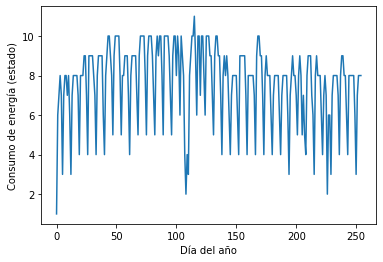

Pi_ij = 0.23684210526315788


In [5]:
import matplotlib.pyplot as plt

# Importar los datos y calcular la energía diaria
vector_energia = energia_diaria('demanda_2019.json')

# Definir los estados
numero_estados = 10
vector_estados = definicion_estados(vector_energia, numero_estados)
print(vector_estados)

# Graficar la evolución de los estados
plt.plot(vector_estados)
plt.xlabel('Día del año')
plt.ylabel('Consumo de energía (estado)')
plt.show()

# Definir la probabilidad de transición de "i" a "j"
i, j = 10, 9
Pi_ij = probabilidad_transicion(vector_estados, numero_estados, i, j)
print('Pi_ij =', Pi_ij)

---
## 4. - Asignaciones del proyecto

### Asignación de parámetros

Las asignaciones requieren de valores de $t$, $i$, $j$ asignados según carné. 

In [6]:
from numpy import random
from scipy import stats

def parametros_asignados(digitos):
    '''Elige un valor t aleatoriamente,
    dos estados arbitrarios i y j
    '''
    
    random.seed(digitos)
    estados = [i+1 for i in range(10)]
    T = stats.expon(2)
    t = int(T.rvs())
    i = estados[random.randint(0, len(estados))]
    j = estados[random.randint(0, len(estados))]
    print('t: {}, i: {}, j: {}'.format(t, i, j))
    return t, i, j

**Ejemplo**: el carné B12345 utiliza los dígitos 12345 y obtiene los parámetros $t$: 4, $i$: 2, $j$: 5.

In [7]:
t, i, j = parametros_asignados(57628)

t: 2, i: 7, j: 1


### 4.1. - Encuesta del curso

* (30%) Completar la encuesta disponible a partir del lunes 7 de diciembre de 2020.





### 4.2. - Construir la matriz de transición de estados

* (30%) Para los datos dados, crear la matriz de probabilidades de transición de estados, considerando que el rango de valores de energía se divide en $N = 10$ estados, donde $i, j \in \{ 1, \ldots, 10 \}$ son estados particulares.

In [9]:
##Con los valores  i:7, j:1
import matplotlib.pyplot as plt

# Definir los estados
numero_estados2 = 10
vector_estados2 = definicion_estados(vector_energia, numero_estados2)
print(vector_estados2)

i2, j2 = 7, 1

##Determinamos matriz de transiciones
matriz_transiciones = np.zeros((numero_estados2, numero_estados2))
for i2 in range (0,len(matriz_transiciones)):
    for j2 in range (0,len(matriz_transiciones[i2])):
        matriz_transiciones[i2][j2]=probabilidad_transicion(vector_estados2, numero_estados2, i2+1, j2+1)
print("La matriz de transiciones es:\n")
print(matriz_transiciones)


[ 1.  6.  7.  8.  7.  3.  7.  8.  8.  7.  8.  6.  3.  7.  8.  8.  8.  8.
  7.  4.  8.  8.  8.  9.  9.  7.  4.  9.  9.  9.  9.  8.  7.  4.  8.  9.
  9.  9.  9.  6.  4.  8.  9. 10. 10.  9.  8.  5.  9. 10. 10. 10. 10.  8.
  5.  8.  8.  9.  9.  9.  7.  4.  8.  9.  9.  9.  9.  7.  5.  9. 10. 10.
 10. 10.  8.  5.  9. 10. 10. 10.  9.  7.  5.  9. 10.  9. 10. 10.  8.  5.
 10. 10. 10. 10.  9.  7.  5.  9. 10. 10.  8. 10.  9.  6. 10.  9.  8.  4.
  2.  4.  3.  8.  9. 10. 10. 11.  9.  6. 10. 10.  7. 10. 10.  8.  6. 10.
 10. 10.  9.  9.  7.  5.  9. 10. 10.  9.  9.  7.  4.  8.  9.  8.  9.  8.
  6.  4.  7.  8.  8.  8.  8.  6.  4.  9.  9.  9.  9.  9.  7.  4.  8.  8.
  8.  8.  8.  7.  4.  9. 10. 10.  9.  9.  7.  4.  8.  9.  8.  8.  8.  6.
  4.  7.  8.  8.  8.  8.  6.  4.  7.  8.  8.  8.  8.  6.  3.  7.  8.  9.
  8.  8.  7.  5.  8.  9.  8.  5.  7.  5.  4.  8.  9.  9.  9.  7.  6.  3.
  8.  9.  8.  8.  8.  6.  4.  7.  8.  7.  2.  6.  6.  3.  7.  8.  8.  8.
  8.  7.  4.  8.  9.  9.  8.  8.  6.  4.  8.  8.  8

### 4.3. - Construcción de la matriz de transición de orden *t* predicción

Para los valores obtenidos en `parametros_asignados()`:

* (20%) Construir la matriz de transición de estados de orden $t$.

* (20%) Determinar la probabilidad de estar en el estado $j$, $t$ días después de estar en el estado $i$.

In [10]:
##Con los valores t:2, i:7, j:1
import matplotlib.pyplot as plt
import numpy as np
from numpy import matmul


#Se sabe que para obtener diferente orden, se multiplican las matrices. En este caso, t=2, entonces sería la matriz a la 2
matriz_orden_t = np.matmul(matriz_transiciones, matriz_transiciones)
print("La matriz de orden 2 es: \n")
print(matriz_orden_t)
print("\n")

#Para determinar la probabilidad t días (2 días) después del estado i=7 sería la posicion i,j de la matriz
print("La probabilidad P_i_ij es:",matriz_orden_t[7][1], "\n")



La matriz de orden 2 es: 

[[0.         0.         0.13888889 0.19444444 0.         0.02777778
  0.02777778 0.         0.         0.08333333]
 [0.         0.01666667 0.10925926 0.12962963 0.         0.01851852
  0.08518519 0.16666667 0.05       0.05555556]
 [0.         0.02016129 0.02016129 0.18478495 0.13763441 0.05349462
  0.02666667 0.33844086 0.04666667 0.02349462]
 [0.         0.00645161 0.00645161 0.08139785 0.07204301 0.09782066
  0.11136905 0.34358679 0.1522619  0.03990399]
 [0.         0.00685484 0.00685484 0.02641577 0.02724014 0.05169611
  0.12592314 0.24926496 0.25977652 0.14024874]
 [0.         0.02123656 0.03666866 0.03773397 0.01075269 0.00487853
  0.25886127 0.30553198 0.09780702 0.10315664]
 [0.         0.01451613 0.0234767  0.04415771 0.02365591 0.05985663
  0.13484531 0.35531975 0.21419921 0.04406338]
 [0.         0.00410753 0.04114456 0.09459737 0.05175627 0.08307049
  0.09909162 0.30849274 0.19893567 0.07814261]
 [0.         0.00576037 0.02064132 0.0750576  0.04646

---

### Universidad de Costa Rica
#### Facultad de Ingeniería
##### Escuela de Ingeniería Eléctrica

---